# Social Network Analysis

### Libraries

In [1]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import json
import networkx as nx
from networkx.algorithms.community import girvan_newman
import community.community_louvain as louvain

In [2]:
# major variables

city = 'Springfield'

### Helper Methods

In [3]:
def generate_graph(nodes, edges):
    '''
    Generate a networkx graph from nodes and edges dataframes
    '''
    G = nx.Graph()
    for _, row in nodes.iterrows():
        G.add_node(row['id'], name=row['name'])
    for _, row in edges.iterrows():
        G.add_edge(row['from'], row['to'], weight=row['weight'], type=row['type'])
    return G

In [4]:
def generate_communities(G, algorithm='girvan_newman'):
    '''
    Generate communities using the specified algorithm
    '''
    if algorithm == 'girvan_newman':
        communities = girvan_newman(G)
        first_iteration_communities = next(communities)
        return first_iteration_communities
    elif algorithm == 'louvain':
        communities = louvain.best_partition(G)
        return communities
    else:
        raise ValueError("Invalid algorithm. Choose 'girvan_newman' or 'louvain'.")

In [5]:
def visualize_graph(G, communities, city, connection):
    '''
    Visualize the graph with nodes colored by community
    '''
    plt.figure(figsize=(12, 5))
    pos = nx.spring_layout(G)
    
    community_colors = {}
    if isinstance(communities, tuple):
        for i, comm_nodes in enumerate(communities):
            for node in comm_nodes:
                community_colors[node] = i
    elif isinstance(communities, dict):
        for node, community_id in communities.items():
            community_colors[node] = community_id
    node_colors = [community_colors[node] for node in G.nodes()]
    
    nx.draw(G, pos,
            node_color=node_colors,
            cmap=plt.cm.tab20,
            node_size=20,
            edge_color='black',
            edgecolors='black',
            width=1,
            with_labels=False)
    
    plt.title(f"{city} - {connection}")
    plt.show()

In [6]:
def store_communities(communities, num_communities=None, filename='communities.json'):
    '''
    Store communities in a JSON file
    '''
    community_data = {"num_communities": num_communities, "communities": []}
    if isinstance(communities, tuple):
        for community_set in communities:
            community_data["communities"].append(list(community_set))
    elif isinstance(communities, dict):
        data = {}
        for node, community_id in communities.items():
            if community_id not in data:
                data[community_id] = []
            data[community_id].append(node)
        for _, nodes in sorted(data.items()):
            community_data["communities"].append(nodes)
    
    else:
        raise ValueError("Unsupported community format. Please provide a tuple of sets or a dictionary.")
    if num_communities is None:
        community_data["num_communities"] = len(community_data["communities"])
    
    with open(filename, 'w') as f:
        json.dump(community_data, f, indent=4)
    print(f"Communities have been stored in {filename}.")

### Friendship Connections

In [7]:
# load friendship data

connection = 'friendships'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [8]:
# generate friendship graph

friendship_graph = generate_graph(nodes, edges)

In [9]:
# generate friendship communities

friendship_communities = generate_communities(friendship_graph, algorithm='louvain')
num_communities = len(set(friendship_communities.values()))

store_communities(friendship_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_friendships_communities.json.


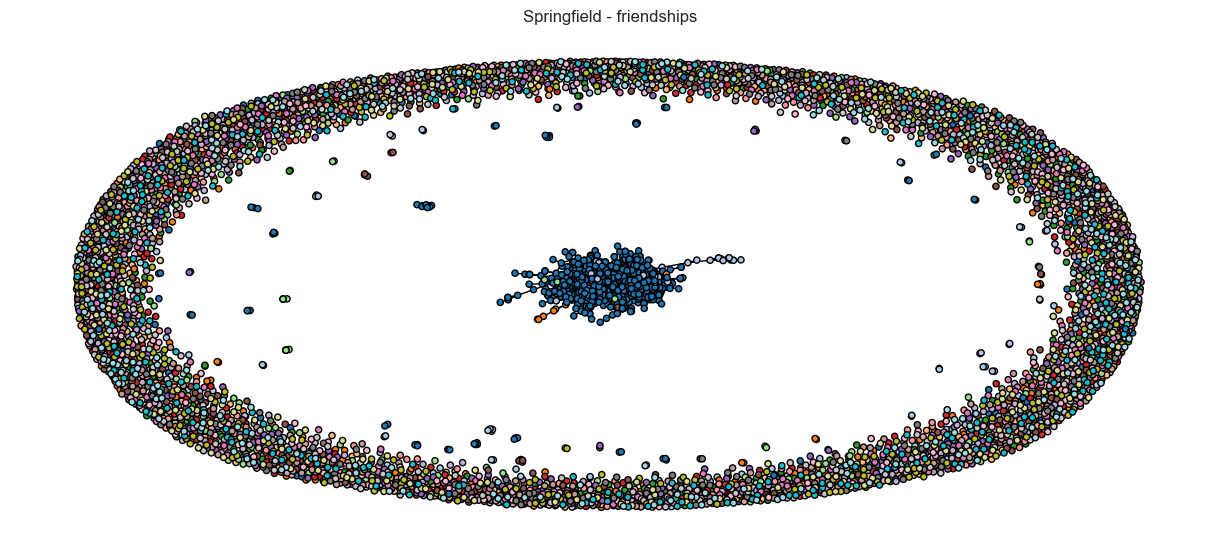

In [10]:
# visualize friendship graph

visualize_graph(friendship_graph, friendship_communities, city, connection)

### Review Connections

In [11]:
# load review data

connection = 'business_reviews'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [12]:
# generate review graph

review_graph = generate_graph(nodes, edges)

In [13]:
# generate review communities

review_communities = generate_communities(review_graph, algorithm='louvain')
num_communities = len(set(review_communities.values()))

store_communities(review_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_business_reviews_communities.json.


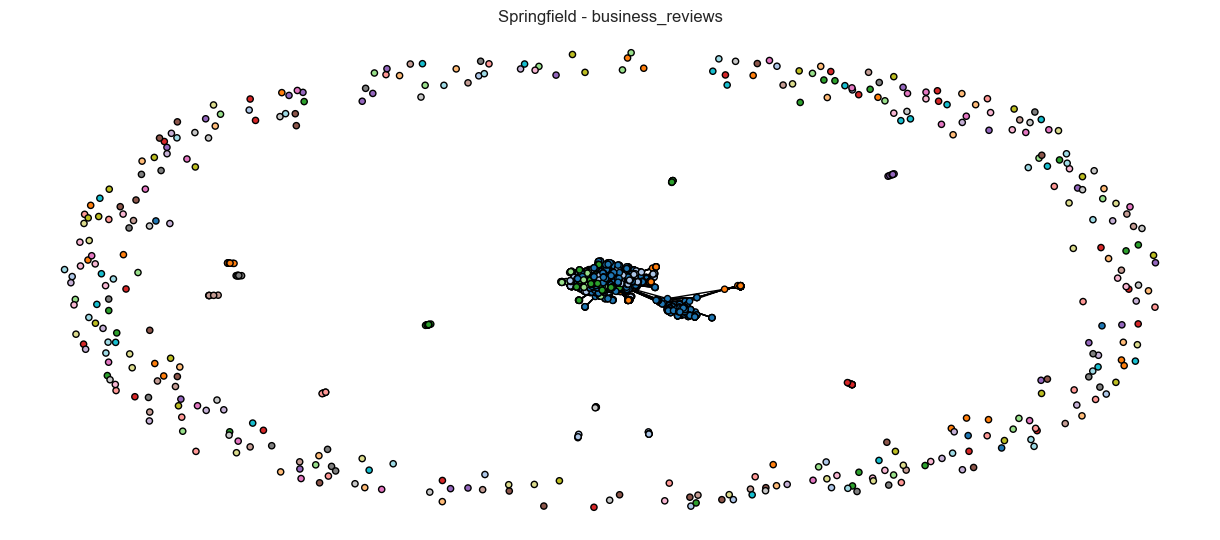

In [14]:
# visualize review graph

visualize_graph(review_graph, review_communities, city, connection)

### Tip Connections

In [15]:
# load tip data

connection = 'business_tips'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [16]:
# generate tip graph

tip_graph = generate_graph(nodes, edges)

In [17]:
# generate tip communities

tip_communities = generate_communities(tip_graph, algorithm='louvain')
num_communities = len(set(tip_communities.values()))

store_communities(tip_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_business_tips_communities.json.


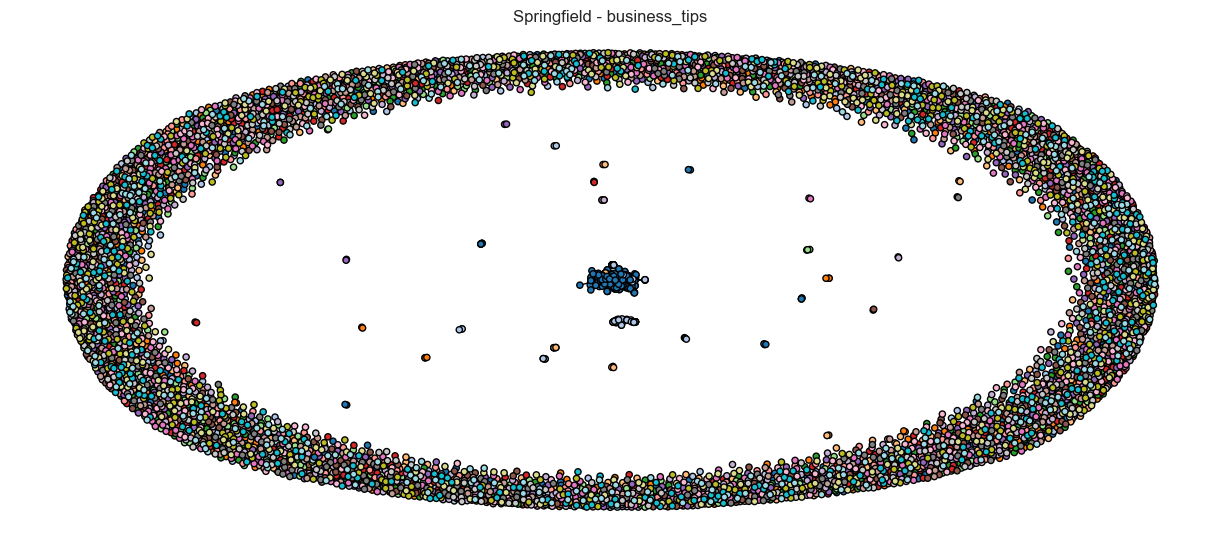

In [18]:
# visualize tip graph

visualize_graph(tip_graph, tip_communities, city, connection)

### Category Connections

In [19]:
# load category data

connection = 'categories'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [20]:
# generate category graph

category_graph = generate_graph(nodes, edges)

In [21]:
# generate category communities

category_communities = generate_communities(category_graph, algorithm='louvain')
num_communities = len(set(category_communities.values()))

store_communities(category_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_categories_communities.json.


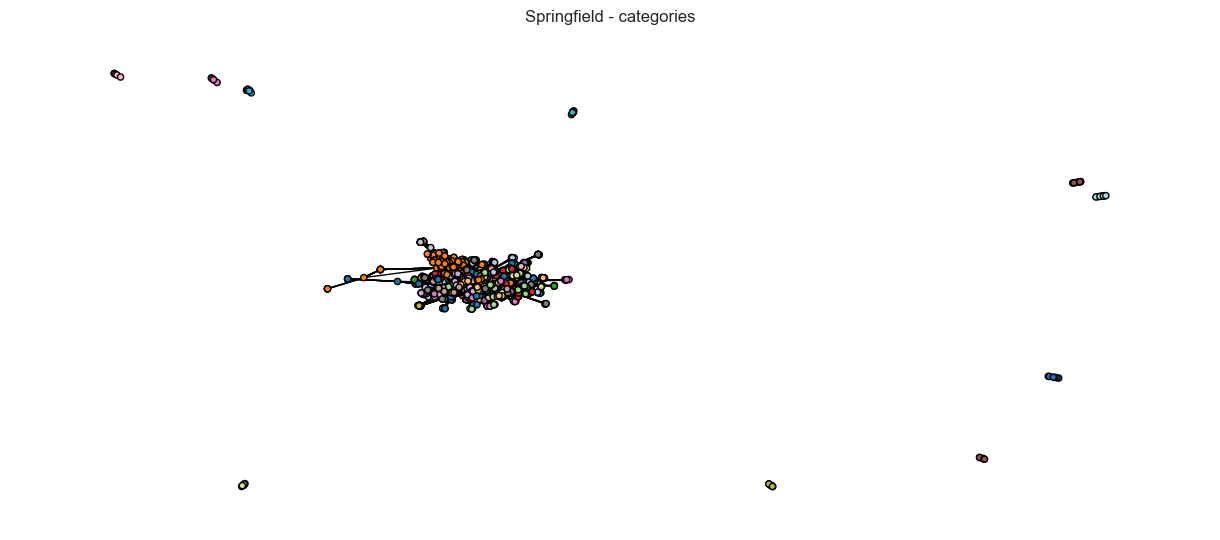

In [22]:
# visualize category graph

visualize_graph(category_graph, category_communities, city, connection)

### Category Connections (with Threshold)

In [23]:
# load threshold category data

connection = 'threshold_categories'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [24]:
# generate threshold category graph

threshold_category_graph = generate_graph(nodes, edges)

In [25]:
# generate threshold category communities

threshold_category_communities = generate_communities(threshold_category_graph, algorithm='louvain')
num_communities = len(set(threshold_category_communities.values()))

store_communities(threshold_category_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_threshold_categories_communities.json.


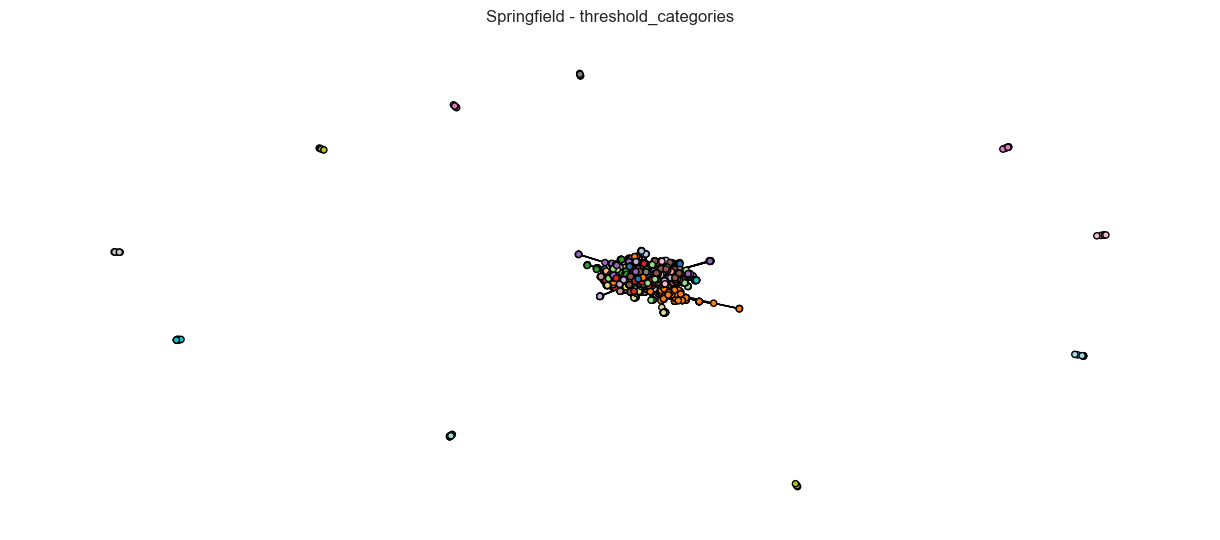

In [26]:
# visualize threshold category graph

visualize_graph(threshold_category_graph, threshold_category_communities, city, connection)

### Combined Connections

In [27]:
# load combined data

connection = 'combined'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [28]:
# generate combined graph

combined_graph = generate_graph(nodes, edges)

In [29]:
# generate combined communities

combined_communities = generate_communities(combined_graph, algorithm='louvain')
num_communities = len(set(combined_communities.values()))

store_communities(combined_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_combined_communities.json.


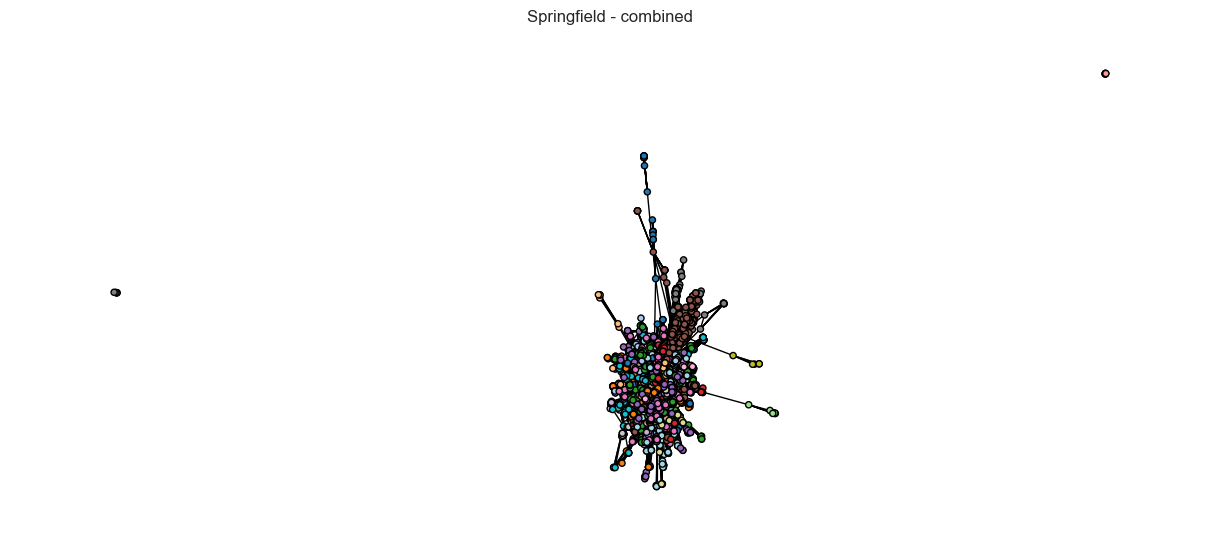

In [30]:
# visualize combined graph

visualize_graph(combined_graph, combined_communities, city, connection)

### Category and Business Review Connections

In [31]:
# load category and review data

connection = 'categories_and_reviews'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [32]:
# generate category and review graph

category_and_review_graph = generate_graph(nodes, edges)

In [33]:
# generate category and review communities

category_and_review_communities = generate_communities(category_and_review_graph, algorithm='louvain')
num_communities = len(set(category_and_review_communities.values()))

store_communities(category_and_review_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_categories_and_reviews_communities.json.


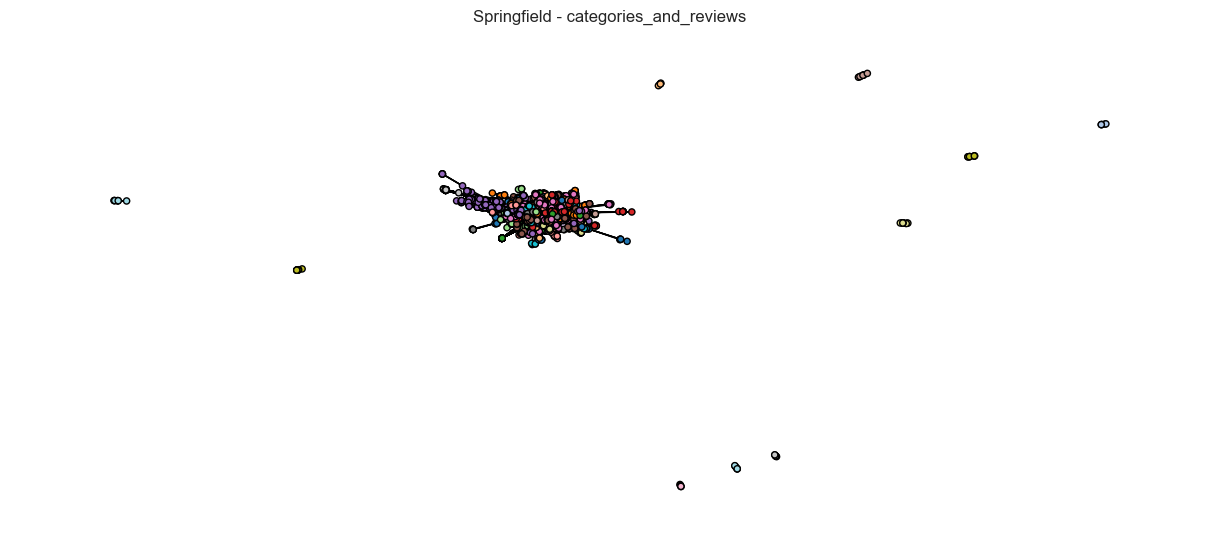

In [34]:
# visualize combined graph

visualize_graph(category_and_review_graph, category_and_review_communities, city, connection)

### Priority Combined Connections

In [35]:
# load priority combined data

connection = 'priority_combined'

nodes = pd.read_csv(f'nodes_and_edges/{city}_{connection}_nodes.csv')
edges = pd.read_csv(f'nodes_and_edges/{city}_{connection}_edges.csv')

In [36]:
# generate priority combined graph

priority_combined_graph = generate_graph(nodes, edges)

In [37]:
# generate priority combined communities

priority_combined_communities = generate_communities(priority_combined_graph, algorithm='louvain')
num_communities = len(set(priority_combined_communities.values()))

store_communities(priority_combined_communities, num_communities, filename=f'communities/{city}_{connection}_communities.json')

Communities have been stored in communities/Springfield_priority_combined_communities.json.


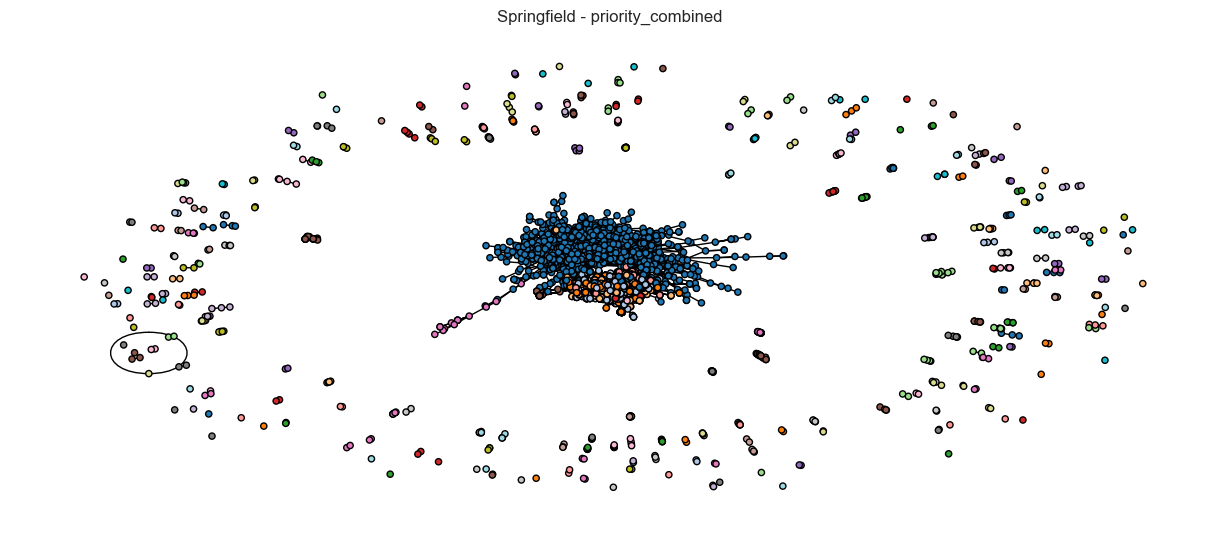

In [38]:
# visualize combined graph

visualize_graph(priority_combined_graph, priority_combined_communities, city, connection)

### Graph Statistics

#### Density

In [93]:
def calculate_density(graph):
    return nx.density(graph)

In [40]:
density_category_and_review_graph = calculate_density(category_and_review_graph)
print(f"Density of category and review graph: {density_category_and_review_graph:0.4f}")

Density of category and review graph: 0.0187


In [41]:
density_priority_combined_graph = calculate_density(priority_combined_graph)
print(f"Density of priority combined graph: {density_priority_combined_graph:0.4f}")

Density of priority combined graph: 0.0056


#### Diameter

In [94]:
def calculate_average_diameter(graph):
    if nx.is_connected(graph):
        diameter_weighted = nx.diameter(graph, weight='weight')
        print(f"Weighted undirected diameter: {diameter_weighted}")
    else:
        components = nx.connected_components(graph)
        diameters = []
        for i, component in enumerate(components, start=1):
            subgraph = graph.subgraph(component)
            diameter = nx.diameter(subgraph, weight='weight')
            diameters.append(diameter)
        
        average_diameter = sum(diameters) / len(diameters)
        print(f"\nAverage diameter of connected components: {average_diameter}")

In [ ]:
print("For category and review graph:")
calculate_average_diameter(category_and_review_graph)

In [ ]:
print("For priority combined graph:")
calculate_average_diameter(priority_combined_graph)

#### Degree Distribution

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

def plot_degree_distribution(graph, ax, title, color):
    degrees = dict(nx.degree(graph, weight='weight'))
    ax.hist(degrees.values(), bins=range(1, max(degrees.values()) + 2), alpha=0.75, label=title, color=color)
    ax.set_xlabel('Degree')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Degree Distribution - {title}')
    ax.legend()

plot_degree_distribution(category_and_review_graph, axes[0], "Category and Review Graph", 'green')
plot_degree_distribution(priority_combined_graph, axes[1], "Priority Combined Graph", 'purple')

plt.tight_layout()
plt.show()

#### Closeness Centrality

In [95]:
def compute_closeness(graph):
    if nx.is_weighted(graph):
        closeness = nx.closeness_centrality(graph, distance='weight')
    else:
        closeness = nx.closeness_centrality(graph)
    return closeness

In [ ]:
category_and_review_closeness = compute_closeness(category_and_review_graph)
category_and_review_closeness_df = pd.DataFrame({'name': list(category_and_review_closeness.keys()), 'closeness': list(category_and_review_closeness.values())})
category_and_review_closeness_df = category_and_review_closeness_df.sort_values(by='closeness', ascending=False)

print("Category and review graph closeness centrality:")
print(category_and_review_closeness_df)

In [ ]:
priority_combined_closeness = compute_closeness(priority_combined_graph)
priority_combined_closeness_df = pd.DataFrame({'name': list(priority_combined_closeness.keys()), 'closeness': list(priority_combined_closeness.values())})
priority_combined_closeness_df = priority_combined_closeness_df.sort_values(by='closeness', ascending=False)

print("Priority combined graph closeness centrality:")
print(priority_combined_closeness_df)

#### Betweenness Centrality

In [96]:
def compute_betweenness(graph):
    num_nodes = len(graph.nodes)
    k = min(1000, num_nodes)
    betweenness = nx.betweenness_centrality(graph, k=k, weight='weight')
    betweenness_df = pd.DataFrame({'name': list(betweenness.keys()), 'betweenness': list(betweenness.values())})
    betweenness_df = betweenness_df.sort_values(by='betweenness', ascending=False)
    return betweenness_df

In [ ]:
category_and_review_betweenness_df = compute_betweenness(category_and_review_graph)

print("Category and review graph betweenness centrality:")
print(category_and_review_betweenness_df)

In [ ]:
priority_combined_betweenness_df = compute_betweenness(priority_combined_graph)

print("Priority combined graph betweenness centrality:")
print(priority_combined_betweenness_df)

#### Edge Betweenness Centrality

In [97]:
def compute_edge_betweenness(graph):
    num_edges = len(graph.edges)
    k = min(1000, num_edges)
    edge_betweenness = nx.edge_betweenness_centrality(graph, k=k, weight='weight')
    return edge_betweenness

In [ ]:
category_and_review_edge_betweenness = compute_edge_betweenness(category_and_review_graph)

print("Category and review graph edge betweenness centrality:")
print(category_and_review_edge_betweenness)

In [ ]:
priority_combined_betweenness = compute_edge_betweenness(priority_combined_graph)

print("Priority combined graph edge betweenness centrality:")
print(priority_combined_betweenness)

#### Average Shortest Path Length

In [98]:
def compute_average_shortest_path_length(graph):
    if nx.is_connected(graph):
        return nx.average_shortest_path_length(graph, weight='weight')
    else:
        avg_lengths = []
        connected_components = nx.connected_components(graph)
        for component in connected_components:
            component_graph = graph.subgraph(component)
            avg_lengths.append(nx.average_shortest_path_length(component_graph, weight='weight'))
        return sum(avg_lengths) / len(avg_lengths)

In [ ]:
print("Average shortest path length for category and review graph:")
print(compute_average_shortest_path_length(category_and_review_graph))

In [ ]:
print("Average shortest path length for priority combined graph:")
print(compute_average_shortest_path_length(priority_combined_graph))

#### Homophily

In [44]:
def compute_homophily(graph):
    return nx.degree_assortativity_coefficient(graph, weight='weight')

In [45]:
print("Homophily for category graph:")
print(f"All network = {compute_homophily(category_graph):.3f}")

Homophily for category graph:
All network = -0.033


In [ ]:
print("Homophily for threshold category graph:")
print(f"All network = {compute_homophily(threshold_category_graph):.3f}")

In [47]:
print("Homophily for combined graph:")
print(f"All network = {compute_homophily(combined_graph):.3f}")

Homophily for combined graph:
All network = -0.035


In [48]:
print("Homophily for category and review graph:")
print(f"All network = {compute_homophily(category_and_review_graph):.3f}")

Homophily for category and review graph:
All network = -0.034


In [53]:
print("Homophily for priority combined graph:")
print(f"All network = {compute_homophily(priority_combined_graph):.3f}")

Homophily for priority combined graph:
All network = 0.162


In [105]:
# running for all connections

connections = [priority_combined_graph]
connection_names = ['Priority Combined']

for i, connection in enumerate(connections):
    print(f"Connection: {connection_names[i]}")
    print(f"Density: {calculate_density(connection):.4f}")
    calculate_average_diameter(connection)
    temp = compute_closeness(connection).values()
    print(f"Avg. Closeness: {sum(temp)/len(temp)}")
    temp = compute_betweenness(connection)['betweenness']
    print(f"Avg. Betweenness: {sum(temp)/len(temp)}")
    temp = compute_edge_betweenness(connection).values()
    print(f"Avg. Edge Betweenness: {sum(temp)/len(temp)}")
    print(f"Average Shortest Path Length: {compute_average_shortest_path_length(connection)}")



Connection: Priority Combined
Density: 0.0056

Average diameter of connected components: 1.0
Avg. Closeness: 0.15227084572142696
Avg. Betweenness: 0.0001502391021242141
Avg. Edge Betweenness: 1.2962596846073763e-06
Average Shortest Path Length: 0.8194620281659067


### Communities Analysis

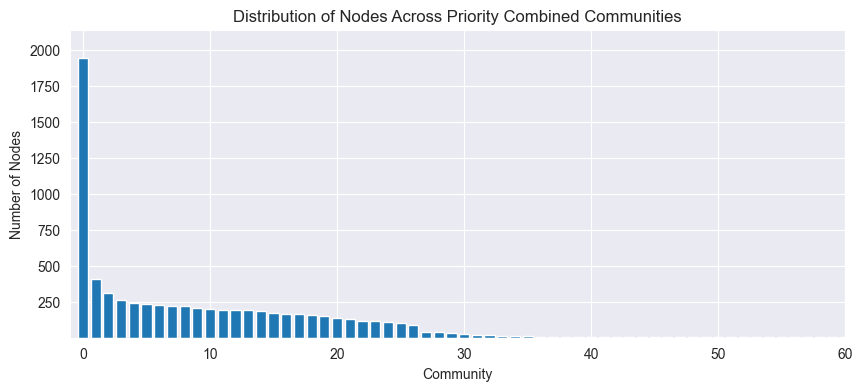

In [92]:
community_counts = {}
for community in priority_combined_communities.values():
    community_counts[community] = community_counts.get(community, 0) + 1

community_counts = {k: v for k, v in sorted(community_counts.items(), key=lambda item: item[1], reverse=True)}

plt.figure(figsize=(10, 4)) 
plt.bar(range(len(community_counts)), community_counts.values())
plt.xlabel('Community')
plt.ylabel('Number of Nodes')
plt.ylim(min(community_counts.values())*0.9, max(community_counts.values())*1.1)
plt.xlim(min(community_counts.keys())-1, 60)
plt.title('Distribution of Nodes Across Priority Combined Communities')
plt.show()

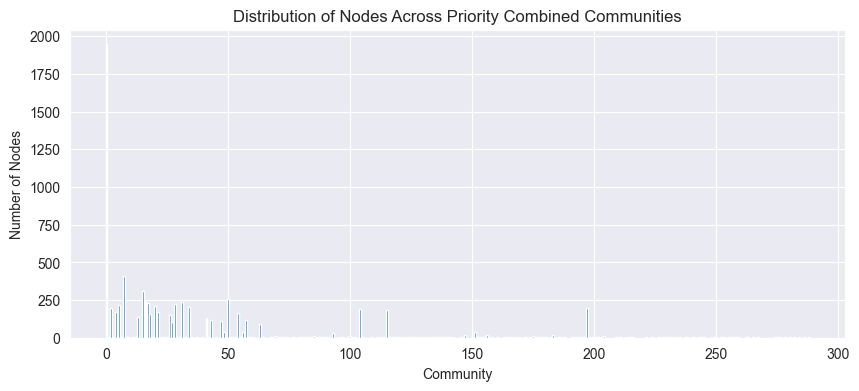

In [59]:
community_counts = {}
for community in priority_combined_communities.values():
    community_counts[community] = community_counts.get(community, 0) + 1

plt.figure(figsize=(10, 4)) 
plt.bar(community_counts.keys(), community_counts.values())
plt.xlabel('Community')
plt.ylabel('Number of Nodes')
plt.title('Distribution of Nodes Across Priority Combined Communities')
plt.show()

### Alone Users Analysis

In [60]:
city = 'Springfield'

users = pd.read_csv(f'filtered_cities/{city}_user.csv')
tips = pd.read_csv(f'filtered_cities/{city}_tip.csv')

users

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,IpLRJY4CP3fXtlEd8Y4GFQ,Robyn,518,2009-04-11 14:35:46,1325,450,348,"2009,2010,2011","hdwDo7CLh9aN_9PckAos4Q, ci-mepWGgsgGT3sFI2mhMg...",35,...,4,2,7,1,35,17,20,20,20,6
1,RgDVC3ZUBqpEe6Y1kPhIpw,Monica,1282,2009-02-23 14:08:31,12640,10005,11149,"2009,2010,2011,2012,2013,2014,2015,2016","sHozd2pcOKwHtPr8VlZJfg, 7mL9cvICl8fuCQTM89a-SA...",804,...,102,108,138,65,898,2584,1731,1731,551,177
2,om5ZiponkpRqUNa3pVPiRg,Andrea,2811,2006-01-18 02:35:04,18545,9225,13824,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...","bQiST5YdWLSH_yk56ccApA, r7Zi52GqnJa6Tb0dqTKlkw...",1002,...,136,88,214,102,1370,2284,1639,1639,437,189
3,KrIL3TIOJI-tjvU6BlcA-g,Elisabeth,141,2010-06-17 22:38:44,225,58,83,"2011,2012","eUlLKiRbX3k4VS3Ko_WxTA, nmiOEav_m5eT08zz8BIi4A...",18,...,5,3,0,0,9,5,7,7,4,0
4,1sGYXSkJHPhJ6wQtc-RbZw,Kimberly,820,2009-07-12 01:03:14,5441,2976,4264,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","9w4vI3LRTA4JdJyzOxeEMw, fNSGyM1NJ91CTO_VfJ5asQ...",149,...,31,43,12,8,154,403,541,541,265,148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,yEGClWugJyBMcOIIm_d0dA,Lady,2,2018-01-18 20:34:46,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7703,q4mOU6YL850_OsrrE1_ScA,Megan,1,2021-02-12 20:12:45,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7704,2brjqRYgw2CYcoDwSKTrog,Katherine,3,2020-01-08 07:43:11,1,0,1,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7705,f9Lm5TrNfVX1JmVXIbtCOg,Bernae,1,2016-06-03 23:40:53,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
# users that ended up alone

def alone_users_stats(connection_temp):
    with open(f'communities/{city}_{connection_temp}_communities.json') as f:
        communities_temp = json.load(f)
        communities_temp = communities_temp['communities']
    
    alone_communities = {i[0] for i in list(filter(lambda x: len(x) == 1, communities_temp))}
    
    users_alone = users[users['user_id'].isin(alone_communities)]
    print("Number of users that ended up alone:")
    print(len(alone_communities), end=" / ")
    print(len(users))
    if len(alone_communities) > 0:
        print("Alone people that have reviewed businesses:")
        reviewed_businesses = len(users_alone[users_alone['review_count'] > 0])
        print(reviewed_businesses, end=" ")
        reviewed_businesses_perc = reviewed_businesses / len(users_alone) * 100
        print(f"({reviewed_businesses_perc:.2f}%)")
        print("Alone people that have written tips:")
        written_tips = len(tips[tips['user_id'].isin(alone_communities)].groupby('user_id'))
        print(written_tips, end=" ")
        written_tips_perc = written_tips / len(users_alone) * 100
        print(f"({written_tips_perc:.2f}%)")
        print("Alone people that have friends:")
        have_friends = len(users_alone[users_alone['friends'].str.len() > 0])
        print(have_friends, end=" ")
        have_friends_perc = have_friends / len(users_alone) * 100
        print(f"({have_friends_perc:.2f}%)")
        print("Alone people that have fans:")
        have_fans = len(users_alone[users_alone['fans'] > 0])
        print(have_fans, end=" ")
        have_fans_perc = have_fans / len(users_alone) * 100
        print(f"({have_fans_perc:.2f}%)")
        print("Alone people that have compliments:")
        have_compliments = len(users_alone[users_alone['compliment_hot'] > 0])
        print(have_compliments, end=" ")
        have_compliments_perc = have_compliments / len(users_alone) * 100
        print(f"({have_compliments_perc:.2f}%)")
        print("Min-Max unused users:")
        print(f"{min(reviewed_businesses_perc, written_tips_perc, have_friends_perc, have_fans_perc, have_compliments_perc):.2f}%", end=" - ")
        print(f"{max(reviewed_businesses_perc, written_tips_perc, have_friends_perc, have_fans_perc, have_compliments_perc):.2f}%")
    print("Information about alone users:")
    return users_alone

In [62]:
alone_users_stats('friendships')

Number of users that ended up alone:
5521 / 7707
Alone people that have reviewed businesses:
5521 (100.00%)
Alone people that have written tips:
500 (9.06%)
Alone people that have friends:
5521 (100.00%)
Alone people that have fans:
847 (15.34%)
Alone people that have compliments:
243 (4.40%)
Min-Max unused users:
4.40% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
20,TZ53SO335VUAeUt14E0eGQ,Ryan,48,2005-08-22 17:59:06,31,9,20,NaN,"gjIqAzkiUhV2lVG1D0oWCg, HSZQcL8T5E5qr9AAXXUnag...",1,...,1,0,0,0,0,2,3,3,1,0
25,Xhdx6LyFdFF_dVabLruhyQ,Ian,12,2006-09-14 01:00:46,10,0,1,NaN,"z0DtzdO_mrk_jBLj7HJfHQ, 2dYg6hwqXRWk8ZE68raB2w...",0,...,0,0,0,0,0,0,0,0,0,0
39,4tVn1wr3PODYI3lzSMjsSw,Tara,40,2008-06-03 03:45:28,88,20,17,NaN,"Ynyc52lgpdKbC5AC03NhIA, I1RZII1OmmhF8d6tHDrlBg...",2,...,0,0,0,0,0,1,2,2,0,0
42,aSL_u-ER-Izu8EeIYzIFfg,Macia,8,2011-12-26 16:51:02,11,2,5,NaN,"zlxNWT1oAf6fsAR57ECzxA, 5z_jGwXmm_GXxrxgzpkBQw...",1,...,0,0,0,0,1,0,0,0,0,0
61,xuobDpcGFkb555nkyQVXXQ,Tommy,42,2007-05-19 19:23:26,34,5,2,NaN,"JJgH70UL9ynkiPXsVANP0A, sGgRxsZP8RyEzEbfTTUDqw...",0,...,0,0,0,0,1,0,2,2,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,yEGClWugJyBMcOIIm_d0dA,Lady,2,2018-01-18 20:34:46,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7703,q4mOU6YL850_OsrrE1_ScA,Megan,1,2021-02-12 20:12:45,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7704,2brjqRYgw2CYcoDwSKTrog,Katherine,3,2020-01-08 07:43:11,1,0,1,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7705,f9Lm5TrNfVX1JmVXIbtCOg,Bernae,1,2016-06-03 23:40:53,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
alone_users_stats('business_reviews')

Number of users that ended up alone:
357 / 7707
Alone people that have reviewed businesses:
357 (100.00%)
Alone people that have written tips:
357 (100.00%)
Alone people that have friends:
357 (100.00%)
Alone people that have fans:
114 (31.93%)
Alone people that have compliments:
60 (16.81%)
Min-Max unused users:
16.81% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
37,8MKygqfspKqG2-X9ycR-Ow,Hunter,189,2008-01-02 03:56:16,672,266,384,"2010,2011","Xw7ZjaGfr0WNVt6s_5KZfA, IpYw-Ygpoo9gI4s-Mwrc1g...",15,...,9,4,0,2,40,66,38,38,24,3
45,EgzZHrUo6M4oYRjEupctzw,RoShawnda,31,2010-02-23 18:14:56,24,3,3,NaN,"47aw_p6m4EWjT_nAhyim0w, TmpNomC5Bg2d9qbsDiKLng...",4,...,0,1,0,0,2,1,0,0,0,0
54,jm6zCII7rtT6y04csSUUfw,Michael,94,2009-07-17 23:36:34,128,37,26,NaN,"AdUvjftNBAJGEsFcEtgL9A, cgdUBrdA36EGO7jfJQX_KA...",6,...,0,0,0,0,1,6,2,2,0,1
64,9sHfCA7_y5DkQM2I3ykHzw,Rob,265,2009-11-13 23:49:49,355,126,146,"2010,2011,2012","0MJ5sKX5uq7Ma5hbl4l3BQ, bJ5FtCtZX3ZZacz2_2PJjA...",13,...,4,1,0,0,8,16,12,12,4,0
80,yBQEOTjFlZkjf3rcwDxAbA,Jim,87,2009-06-03 10:46:55,123,63,43,NaN,"VEj1OuO6QrQMXFhuMZJ8cQ, ak2QYmZnp9CfzN09lI-5Yw...",2,...,0,0,0,0,7,7,6,6,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7500,jYo3l6ZWxpnQ6b_qGw3uXw,Kim,2,2016-03-22 18:22:28,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7560,awRuQEExlF-D1pZYaeOxqA,April,1,2015-09-26 16:28:41,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7564,15zeWSGjXz7KPixZCo74Nw,Dawn,1,2015-03-25 18:14:02,1,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7647,t4OjQh8waII8rQWsAzTiZw,Rackell,6,2015-11-15 02:17:03,3,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
alone_users_stats('business_tips')

Number of users that ended up alone:
6856 / 7707
Alone people that have reviewed businesses:
6856 (100.00%)
Alone people that have written tips:
56 (0.82%)
Alone people that have friends:
6856 (100.00%)
Alone people that have fans:
1654 (24.12%)
Alone people that have compliments:
732 (10.68%)
Min-Max unused users:
0.82% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
1,RgDVC3ZUBqpEe6Y1kPhIpw,Monica,1282,2009-02-23 14:08:31,12640,10005,11149,"2009,2010,2011,2012,2013,2014,2015,2016","sHozd2pcOKwHtPr8VlZJfg, 7mL9cvICl8fuCQTM89a-SA...",804,...,102,108,138,65,898,2584,1731,1731,551,177
2,om5ZiponkpRqUNa3pVPiRg,Andrea,2811,2006-01-18 02:35:04,18545,9225,13824,"2006,2007,2008,2009,2010,2011,2012,2013,2014,2...","bQiST5YdWLSH_yk56ccApA, r7Zi52GqnJa6Tb0dqTKlkw...",1002,...,136,88,214,102,1370,2284,1639,1639,437,189
3,KrIL3TIOJI-tjvU6BlcA-g,Elisabeth,141,2010-06-17 22:38:44,225,58,83,"2011,2012","eUlLKiRbX3k4VS3Ko_WxTA, nmiOEav_m5eT08zz8BIi4A...",18,...,5,3,0,0,9,5,7,7,4,0
4,1sGYXSkJHPhJ6wQtc-RbZw,Kimberly,820,2009-07-12 01:03:14,5441,2976,4264,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","9w4vI3LRTA4JdJyzOxeEMw, fNSGyM1NJ91CTO_VfJ5asQ...",149,...,31,43,12,8,154,403,541,541,265,148
6,SH-GRUQlUZTco0ofRbwVdQ,Carter,197,2011-05-13 18:30:04,230,39,62,"2014,2015,2016,2019,20,20,2021","W0SjTWWduPRHpT23s_42zw, ICKvyNDumMVWmwL8iBVHIQ...",15,...,2,2,0,0,12,11,6,6,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,yEGClWugJyBMcOIIm_d0dA,Lady,2,2018-01-18 20:34:46,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7703,q4mOU6YL850_OsrrE1_ScA,Megan,1,2021-02-12 20:12:45,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7704,2brjqRYgw2CYcoDwSKTrog,Katherine,3,2020-01-08 07:43:11,1,0,1,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0
7705,f9Lm5TrNfVX1JmVXIbtCOg,Bernae,1,2016-06-03 23:40:53,0,0,0,NaN,None,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
alone_users_stats('categories')

Number of users that ended up alone:
0 / 7707
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos


In [ ]:
alone_users_stats('threshold_categories')

In [66]:
alone_users_stats('combined')

Number of users that ended up alone:
0 / 7707
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos


In [67]:
alone_users_stats('categories_and_reviews')

Number of users that ended up alone:
0 / 7707
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos


In [68]:
alone_users_stats('priority_combined')

Number of users that ended up alone:
69 / 7707
Alone people that have reviewed businesses:
68 (100.00%)
Alone people that have written tips:
65 (95.59%)
Alone people that have friends:
68 (100.00%)
Alone people that have fans:
16 (23.53%)
Alone people that have compliments:
5 (7.35%)
Min-Max unused users:
7.35% - 100.00%
Information about alone users:


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
110,Jxo1vOk_tf8DelsXyQbbFw,lin,411,2009-06-20 22:25:08,363,106,119,"2012,2013,2014,2015","Lzkp8TNrCDk7hBwAjBNvQA, cEDMie5DjE_00sJ23H2q9Q...",20,...,2,1,1,0,12,8,16,16,6,1
256,G8tS7aU-HMVHptdc0vF1SA,Danielle,6,2012-03-20 15:33:15,13,0,0,NaN,"FPCf0OibBvnONynzuAd4xw, 1P2LJR7pdttVgTObeMtkog...",1,...,0,0,0,0,0,0,0,0,0,0
508,WJrvdZyM90W5NX7polzqPA,John,18,2009-11-23 19:39:35,9,1,1,NaN,"DtdIre_BvHNPPwEJa34SYw, qy90H2bxzAbuKB5pmBxWrw...",1,...,0,0,0,0,2,0,0,0,0,0
520,jIlzQ_edplxKvVKEggf3og,Noelle,7,2011-07-29 13:57:54,3,1,0,NaN,"oW3CVqv7fcSr1_tOfN_dsg, C6lKpHoaSQf2tuCNkXkvKw...",0,...,0,0,0,0,0,1,0,0,0,0
573,q27tI9Pnxiz9BPyAONzkUw,Kirk,10,2011-12-31 16:07:29,18,5,2,NaN,"LEFopCCrGbJFhSoYs3jhwA, 1vlpiPDs3h8VU6H2eZ_hSw...",1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7340,fpY0TBHNYpbg3C8T1TUCTg,Harold,90,2012-03-18 17:37:43,1025,437,920,"2018,2019,2021","wO44-Kckzm-dVxgRkc-sfA, j4r7DqJDPBN6-TSgAn07Gg...",83,...,10,7,1,0,99,362,283,283,21,355
7349,NS1xH4I3s7dbQYSbqeUURA,Kesley,2,2018-01-18 01:08:14,1,1,0,NaN,"Wleq7eJDw4XFyE6JzB8Tuw, 1hxGoW2nxC6qQ9ynkM9_Fw...",0,...,0,0,0,0,0,0,0,0,0,0
7449,hJ8MRJfziiT7GfFj674ung,Maria,1,2013-09-29 21:24:25,1,0,0,NaN,"qEm9zp6BD9fSEmyOEzWZSA, 6VZ8ru1PaQAoToqQjhnUFQ...",0,...,0,0,0,0,0,0,0,0,0,0
7458,XsdRPNuf3WxgRuqqVemaRQ,Amanda,2,2010-03-15 21:28:56,5,1,1,NaN,Y4LXalFVIbu1fY9WVupObA,0,...,0,0,0,0,0,0,0,0,0,0
